##**IMPORTING LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##**READING DATA**

In [ ]:
!unzip '/content/mnist.zip'

Archive:  /content/mnist.zip
  inflating: mnist_test.csv          
  inflating: mnist_train.csv         


In [ ]:
train = pd.read_csv('/content/mnist_train.csv')
test = pd.read_csv('/content/mnist_test.csv')

X_train= (train.drop(['label'], axis=1).values)/255
X_test= (test.drop(['label'], axis=1).values)/255
y_train= train.loc[:, 'label']
y_test= test.loc[:, 'label'].values

print(f'Number of training examples: {X_train.shape[0]}')
print(f'Number of testing examples: {X_test.shape[0]}')

Number of training examples: 60000
Number of testing examples: 10000


### **Plotting few images from training set**

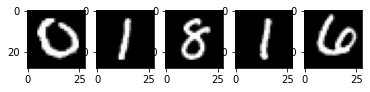

In [ ]:
_,axes= plt.subplots(1,5)
random_idx= np.random.randint(0,60000,size=5)
for i in range(5):
  axes[i].imshow(X_train[random_idx[i],:].reshape(28,28), cmap='gray')
plt.show()

## **DEFINING NETWORK FOR CLASSIFICATION**

In [ ]:
class Net():
  def __init__(self, layer_dim):
    layer_in, hid_layer1, hid_layer2, layer_out= layer_dim
    self.param_dict= {}
    self.param_dict['w1']= np.random.randn(hid_layer1, layer_in)*np.sqrt(1./hid_layer1)
    self.param_dict['w2']= np.random.randn(hid_layer2, hid_layer1)*np.sqrt(1./hid_layer1)
    self.param_dict['w3']= np.random.randn(layer_out, hid_layer2)*np.sqrt(1./layer_out)
    self.param_dict['b1'] = np.zeros(hid_layer1)
    self.param_dict['b2'] = np.zeros(hid_layer2)
    self.param_dict['b3'] = np.zeros(layer_out)
    self.epochs=2000
    self.lr= 0.001
    self.batch_size= 512
  
  def full_pass(self, x, y):
    n, dims= x.shape
    w1, w2, w3= self.param_dict['w1'], self.param_dict['w2'], self.param_dict['w3']
    b1, b2, b3= self.param_dict['b1'], self.param_dict['b2'], self.param_dict['b3']
    gradient_dict= {}
    a1, temp_act1= self.fwdprop_layer_act(w1,b1,x)
    z2, temp2= self.fwdprop_layer_z(w2,b2,a1)
    a2, temp_act2= self.ReLU(z2)
    z3, temp3= self.fwdprop_layer_z(w3,b3,a2)
    delta= z3-np.max(z3,axis=1,keepdims= True)
    o= np.sum(np.exp(delta),axis=1,keepdims= True)
    log_p= delta-np.log(o)
    p= np.exp(log_p)                                
    softmax_loss= -np.sum(log_p[np.arange(n),y])/n
    d_output= p
    d_output[np.arange(n), y]= d_output[np.arange(n), y]-1
    gradient_a2,gradient_w3,gradient_b3= self.backprop_layer_z(d_output, temp3)
    gradient_z2= self.d_ReLU(gradient_a2, temp_act2)
    gradient_a1,gradient_w2,gradient_b2= self.backprop_layer_z(gradient_z2, temp2)
    d_x, gradient_w1, gradient_b1= self.backprop_layer_act(gradient_a1, temp_act1)
    gradient_dict['w1'], gradient_dict['w2'], gradient_dict['w3']= gradient_w1, gradient_w2, gradient_w3
    gradient_dict['b1'], gradient_dict['b2'], gradient_dict['b3']= gradient_b1, gradient_b2, gradient_b3
    return softmax_loss, gradient_dict
  
  def fwdprop_layer_z(self,w,b,x):
    n,d= x.shape[0], np.prod(x.shape[1:])
    x_reshape= np.reshape(x, (n,d))
    layer_output= np.dot(x_reshape,w.T)+b
    return layer_output, (x,w,b)

  def backprop_layer_act(self,grad,temp_dict):
    dz,da= temp_dict
    d_relu= self.d_ReLU(grad,da)
    return self.backprop_layer_z(d_relu,dz)

  def backprop_layer_z(self, grad, temp_dict):
    x,w,b= temp_dict
    n,d= x.shape[0], np.prod(x.shape[1:])
    x_reshape= np.reshape(x, (n,d))
    dx_out= np.dot(grad, w)
    dx= dx_out.reshape(x.shape)
    db= np.sum(grad,axis=0)
    dw= np.dot(x_reshape.T,grad)
    return dx,dw,db
  
  def fwdprop_layer_act(self,w,b,x):
    z,i= self.fwdprop_layer_z(w,b,x)
    act,j= self.ReLU(z)
    temp= (i,j)
    return act, temp

  def ReLU(self, x):
    return np.maximum(0,x), x
  
  def d_ReLU(self, grad, x):
    bool_x= (x>0)
    return bool_x*grad
    
  def train(self, x_train, y_train, x_test, y_test):
    train_size= x_train.shape[0]
    losses, test_accs= [], []
    train_accs= []
    for epoch in range(self.epochs):
      id= np.random.choice(train_size, self.batch_size)
      batch_x= x_train[id]
      batch_y= y_train[id]
      loss, gradient_dict= self.full_pass(batch_x,batch_y)
      losses.append(loss)
      self.param_dict['w1']= self.param_dict['w1']-self.lr*gradient_dict['w1'].T
      self.param_dict['w2']= self.param_dict['w2']-self.lr*gradient_dict['w2'].T
      self.param_dict['w3']= self.param_dict['w3']-self.lr*gradient_dict['w3'].T
      self.param_dict['b1']= self.param_dict['b1']-self.lr*gradient_dict['b1']
      self.param_dict['b2']= self.param_dict['b2']-self.lr*gradient_dict['b2']
      self.param_dict['b3']= self.param_dict['b3']-self.lr*gradient_dict['b3']
      train_acc = (self.predict(batch_x)==batch_y).mean()
      test_acc= (self.predict(x_test)==y_test).mean()
      print(f'Epoch: {epoch}; Loss: {loss}; Train Acc: {train_acc}; Test Accuracy: {test_acc}')
      train_accs.append(train_acc)
      test_accs.append(test_accs)
    return losses, train_accs, test_accs
  
  def predict(self, x):
    w1, w2, w3= self.param_dict['w1'], self.param_dict['w2'], self.param_dict['w3']
    b1, b2, b3= self.param_dict['b1'], self.param_dict['b2'], self.param_dict['b3']
    act1, i= self.fwdprop_layer_act(w1,b1,x)
    z2, i= self.fwdprop_layer_z(w2,b2,act1)
    act2, i= self.ReLU(z2)
    z3, i= self.fwdprop_layer_z(w3,b3,act2)
    out= np.argmax(z3, axis=1)
    return out
   

In [ ]:
MNIST_net= Net([784,256,128,10])
losses, train_accs, test_accs= MNIST_net.train(X_train,y_train,X_test,y_test)

Epoch: 0; Loss: 3.061831123292322; Train Acc: 0.19921875; Test Accuracy: 0.1998
Epoch: 1; Loss: 4.323247296134571; Train Acc: 0.16015625; Test Accuracy: 0.1324
Epoch: 2; Loss: 6.351647992533726; Train Acc: 0.173828125; Test Accuracy: 0.2032
Epoch: 3; Loss: 3.318966691245629; Train Acc: 0.33203125; Test Accuracy: 0.3331
Epoch: 4; Loss: 2.089031928597893; Train Acc: 0.560546875; Test Accuracy: 0.5214
Epoch: 5; Loss: 1.79296575373733; Train Acc: 0.576171875; Test Accuracy: 0.5362
Epoch: 6; Loss: 1.5456508557765414; Train Acc: 0.658203125; Test Accuracy: 0.6258
Epoch: 7; Loss: 1.2491392635440288; Train Acc: 0.49609375; Test Accuracy: 0.4748
Epoch: 8; Loss: 1.4366385298726145; Train Acc: 0.37109375; Test Accuracy: 0.363
Epoch: 9; Loss: 1.78196545837574; Train Acc: 0.349609375; Test Accuracy: 0.3585
Epoch: 10; Loss: 1.983278581375133; Train Acc: 0.568359375; Test Accuracy: 0.5517
Epoch: 11; Loss: 1.5730787756504638; Train Acc: 0.634765625; Test Accuracy: 0.6093
Epoch: 12; Loss: 1.27970065191

#### **Losses over iterations**

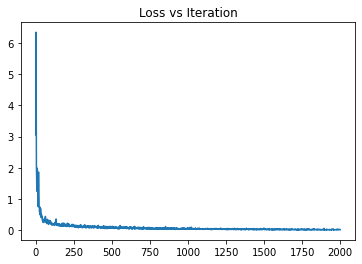

In [ ]:
plt.plot(losses)
plt.title('Loss vs Iteration')
plt.show()

#### **Checking predictions of random test images**

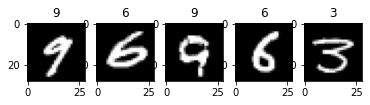

In [ ]:
y_pred= MNIST_net.predict(X_test)
test_imgs= X_test.reshape(-1,28,28)
random_idx= np.random.choice(10000,5)
_,axes= plt.subplots(1,5)
for i in range(5):
  img= test_imgs[random_idx[i]]
  axes[i].imshow(img.reshape(28,28), cmap='gray')
  axes[i].set_title(y_pred[random_idx[i]])
plt.show()

#### **Test Accuracy:**

In [ ]:
print(f'Test Accuracy: {(MNIST_net.predict(X_test)==y_test).mean()}')

Test Accuracy: 0.9801
